# Kmeans avec PIG

auteurs : *P. Atalaya, M. Gubri M*

[k-means](https://en.wikipedia.org/wiki/K-means_clustering) est un algorithme de clustering relativement simple qu'on cherche à paralléliser.

In [62]:
import pyensae
%nb_menu

In [63]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add

SyntaxError: invalid syntax (<ipython-input-63-b2e8a1549adb>, line 1)

### Algorithme

L'algorithme K-means est un algorithme de partitionnement de données relevant de l'apprentissage automatique (plus précisément de l'apprentissage non-supervisé). C'est une méthode dont le but est de diviser des observations en K partitions (clusters) dans lesquelles chaque observation appartient à la partition qui lui ressemble le plus. Le nombre de partitions possibles des observations augmentant de manière exponentielle, il est nécessaire de recourir à un algorithme convergeant rapidement. Un tel algorithme est décrit dans la section suivante.

D'une manière générale, l'algorithme des K-means que nous avons utilisé s’articule de la manière suivante :

**Initialisation**

- Centrage et réduction des variables numériques
- Choisir K points qui représentent la position moyenne des partitions $m_1^{(1)},\ldots,m_K^{(1)}$ initiales (au hasard par exemple)

**Tant que le critère d’arrêt n’est pas atteint :**

- Assigner chaque observation à la partition la plus proche

$$S_i^{(t)} = \left\{ \mathbf x_j : \big\| \mathbf x_j - \mathbf m^{(t)}_i \big\| \leq \big\| \mathbf x_j - \mathbf m^{(t)}_{i^*} \big\|\ \forall\ i^*=1,\ldots,k \right\}$$

- Mettre à jour la moyenne de chaque cluster

$$\mathbf m^{(t+1)}_i = \frac{1}{|S^{(t)}_i|} \sum_{\mathbf x_j \in S^{(t)}_i} \mathbf x_j$$

Il existe différents critères d’arrêt pour l'algorithme des K-means. Nous avons choisi comme critère d'arrêt de l'algorithme le non changement de la partition engendrée par deux itérations successives.

Enfin, lorsque la distance utilisée dans l'algorithme des K-means est la distance euclidienne, il est conseillé de centrer et réduire les différentes variables afin que le partitionnement accorde une importance « semblable » aux différentes variables et c’est ce que nous avons fait en amont des itérations de l'algorithme dans la partie initialisation.

### Données

La base de données utilisée est issue du « center for machine learning » de l’université de Californie. Les données ainsi que leur description complètes sont disponibles [ici](https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation). Cette base de données comporte 245057 observations de pixels décomposés dans l’espace des couleurs RGB (*red, green, blue*). En effet, l'œil humain distinguant les couleurs à travers 3 récepteurs appelés cônes, cela signifie que toute couleur perçue par l’être humain peut se définir par un point dans un espace à trois dimensions. Parmi les espaces de couleur les plus utilisés, la représentation RGB décompose tout pixel dans le système des trois couleurs primaires : le rouge, le bleu et le vert. L’intensité des 3 couleurs primaires est représentée par une valeur numérique variant de 0 à 255. La base de données utilisée comporte 4 variables :

- les 3 variables numériques d’intensité lumineuse (rouge, vert et bleu) ;
- 1 variable binaire indiquant si le pixel correspond à un visage humain ou non (50859 observations de visage humain, 194198 non).

Pour les pixels correspondant à des visages humains, ceux-ci ont été collectés sur des individus de différents groupes d’âge et de couleur de peau. Dans notre cas, l’algorithme des K-means a été utilisé de manière non-supervisé (en ignorant la variable binaire) afin d’étudier les capacités de segmentation de l’algorithme dans la reconnaissance de pixels appartenant à des visages humains ou non. Il est à noter que l’espace des couleurs RGB est utilisé dans des applications de reconnaissance faciale ou encore dans le suivi d’objet. A titre d’exemple, la Kinect développée par Microsoft pour sa console de jeu X-Box 360 dispose d’un capteur RGB permettant de détecter les mouvement du joueur.

### Implémentation

Afin d'implémenter l'algorithme précédemment décrit sur les données RGB, nous avons développé un code dans les langages Python et PIG permettant d'effectuer des calculs répartis grâce à l'architecture Map/Reduce proposée sur le serveur Cloudera. C'est le module pyensae qui nous a permis de faire interagir ces 2 langages de programmation avec le serveur Cloudera.

Pour paralléliser l'algorithme des K-means, nous nous sommes aidés de l'article de W.Zhao, H.Ma, Q.He, *Parallel K-Means Clustering Based on
MapReduce*, Cloud Computing, Springer Berlin Heidelberg, 2009 [[lien](http://link.springer.com/chapter/10.1007%2F978-3-642-10665-1_71)] et [[pdf](http://mldm.ict.ac.cn/pweb/pubDownLoad.htm?id=89)].


**Choix techniques**

Nous avons utilisé PIG autant que possible afin que notre méthode et notre code soit adaptable à une plus grosse échelles de données. Ainsi, l'intégralité des calculs décrits précédemment sont faits de manière distribuée. Notre code pourrait donc fonctionner sur des données beaucoup plus volumineuses, de plusieurs Gio.

Pour des raisons de simplicité, nous avons choisis d'implémenter un K-means avec $K = 2$, c'est à dire que nous partitionnons $ \mathbb{R}^3 $ en deux.

**Difficultés**

Nous avons rencontré plusieurs difficultés dans la réalisation de ce projet :

- Nous avions à l'origine développé nos codes pour Azure. Cependant, à un moment nous n'arrivions plus à lancer de job dessus, nous avons donc changé et adapté notre code peut utiliser Cloudera. Nous n'avons pas regretté ce changement grâce notamment aux possibilités offertes par la commande ``%jobsyntaxe`` ;
- Récupérer le statut d'un job a été un peu compliqué sur Cloudera. Cela est nécessaire afin que nous puissions lancé les itérations successivement.


### Connexion à la passerelle et chargement des données sur le cluster

In [3]:
import pyensae
import pyquickhelper
import os

In [4]:
pyensae.download_data("Skin_NonSkin.txt", website="https://archive.ics.uci.edu/ml/machine-learning-databases/00229/")
os.listdir()

    downloading of  https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt  to  Skin_NonSkin.txt


['.ipynb_checkpoints',
 '2015_factorisation_matrice.ipynb',
 '2015_kmeans.ipynb',
 '2015_page_rank.ipynb',
 'Creation_Graph.pig',
 'DataGoogle.txt',
 'DataTEST.txt',
 'iteration.pig',
 'Skin_NonSkin.txt',
 'stderr',
 'stdout',
 'web-Google.txt',
 'web-Google.txt.gz']

In [6]:
params={"server":"", "username":"", "password":""}
pyquickhelper.ipythonhelper.open_html_form(params=params, title="server + credentials", key_save="params")

In [7]:
import pyensae
password = params["password"]
server = params["server"]
username = params["username"]
client = %remote_open
client

In [8]:
%remote_up Skin_NonSkin.txt Skin_NonSkin.txt

'Skin_NonSkin.txt'

In [11]:
%remote_cmd ls -l *.txt

In [12]:
%remote_cmd hdfs dfs -put Skin_NonSkin.txt ./Skin_NonSkin.txt

In [14]:
%remote_cmd hdfs dfs -ls *.txt

In [18]:
%remote_cmd hdfs dfs -tail Skin_NonSkin.txt

In [14]:
# en cas d'éxécution précédente
#%remote_cmd hdfs dfs -rmr donnees_normalisees init_random moyennes ecartstypes nb_obervations
#%remote_cmd hdfs dfs -rmr output_iter*
#%remote_cmd hdfs dfs -rmr diff_cluster

### Nombre d'observations

Nous enregistrons le script PIG pour calculer le nombre d'observations sur la passerelle. 

In [19]:
%%PIG nb_obervations.pig
A = LOAD 'Skin_NonSkin.txt' 
    USING PigStorage('\t') 
    AS ( f1:int, f2:int, f3:int, face:int);
B = GROUP A ALL; 
C = FOREACH B 
    GENERATE COUNT(A.face) AS total; 
STORE C 
INTO 'nb_obervations' 
USING PigStorage(',') ;

Nous verifions ensuite la syntaxe.

In [20]:
%jobsyntax nb_obervations.pig

La syntaxe étant correcte, on lance le job sur le cluster.

In [21]:
client.pig_submit("nb_obervations.pig", redirection="redirection" )

('', '')

Une fois le job terminé, les données en sorties sont visibles. 

In [25]:
%remote_cmd hdfs dfs -ls nb_obervations

Et nous pouvons accéder à leurs contenus. Ici, nous avons 245 057 observations.

In [26]:
%remote_cmd hdfs dfs -tail nb_obervations/part-r-00000

### Centrer et réduire les données

Pour que l'algorithme fonctionne correctement, nous normalisons les données. Notons que l'on stocke les moyennes et écarts-types afin de pouvoir faire l'opération inverse pour plus tard.

In [23]:
%%PIG centrer_reduire.pig
A = LOAD 'Skin_NonSkin.txt' 
    USING PigStorage('\t') 
    AS ( f1:int, f2:int, f3:int, face:int);
B = GROUP A ALL;
C = FOREACH B 
    GENERATE AVG(A.f1) AS f1m, AVG(A.f2) AS f2m, AVG(A.f3) AS f3m, A.face AS face;
D = FOREACH A 
    GENERATE f1 - (float)C.f1m AS f1, f2 - (float)C.f2m AS f2, f3 - (float)C.f3m AS f3, face;
D2 = FOREACH D 
     GENERATE f1*f1 AS f1, f2*f2 AS f2, f3*f3 AS f3, face;
E = GROUP D2 ALL;
F = FOREACH E 
    GENERATE AVG(D2.f1) AS f1v, AVG(D2.f2) AS f2v, AVG(D2.f3) AS f3v, D2.face AS face;
G = FOREACH F 
    GENERATE SQRT(F.f1v) AS f1e, SQRT(F.f2v) AS f2e, SQRT(F.f3v) AS f3e, face;
H = FOREACH D 
    GENERATE f1 / (float)G.f1e AS f1, f2 / (float)G.f2e AS f2, f3 / (float)G.f3e AS f3, face;

moyennes = FOREACH C 
           GENERATE f1m, f2m, f3m ;
ecarttypes = FOREACH G 
             GENERATE f1e, f2e, f3e ;

STORE H INTO 'donnees_normalisees' USING PigStorage(',') ;
STORE moyennes INTO 'moyennes' USING PigStorage(',') ;
STORE ecarttypes INTO 'ecartstypes' USING PigStorage(',') ;

In [24]:
%jobsyntax centrer_reduire.pig

In [27]:
client.pig_submit("centrer_reduire.pig", redirection="redirection" )

('', '')

In [29]:
%remote_cmd hdfs dfs -ls donnees_normalisees

In [30]:
%remote_cmd hdfs dfs -tail donnees_normalisees/part-m-00000

### Initialisation aléatoire des clusters

Nous utilisons l'instruction ``` RANDOM``` pour générer une variable aléatoire uniforme sur [0,1], que nous arrondissons afin d'assigner un numéro de cluster aléatoire à toutes les observations.

In [31]:
%%PIG init_random.pig
A = LOAD 'donnees_normalisees' 
    USING PigStorage(',') 
    AS ( f1:float, f2:float, f3:float, face:int);
B = FOREACH A GENERATE f1, f2, f3, face, RANDOM() AS cluster ;
C = FOREACH B GENERATE f1, f2, f3, face, ROUND(cluster) ;

STORE C 
INTO 'init_random' 
USING PigStorage(',');

In [32]:
%jobsyntax init_random.pig

In [33]:
client.pig_submit("init_random.pig", redirection="redirection" )

('', '')

In [35]:
%remote_cmd hdfs dfs -ls init_random

In [36]:
%remote_cmd hdfs dfs -tail init_random/part-m-00000

### Corps de l'algorithme

Une fois les données centrées et réduites et les 2 clusters initialisés aléatoirement, nous exécutons itérativement le cœur de l'algorithme, constitué des calculs suivants :
1. Calculer les nouvelles coordonnées des centroïdes des clusters ;
2. Calculer la distance de chaque observation à chaque centroïde ;
3. Assigner le cluster le plus proche pour chaque observation ;
4. Calculer la condition d'arrêt.

Ainsi, au sein de la première itération nous calculons les centres initiaux des clusters. Ces trois étapes sont réalisées en PIG dans une seule et même requête, dont le code est ci-dessous. Cette requête sera lancée jusqu'à ce que la condition d'arrêt soit satisfaite, ou si l'algorithme dépasse un nombre maximum d'itérations (fixé ici à 50).

Nous avons choisi comme condition d'arrêt le fait que les clusters soient identiques à l'étape précédente pour toutes les observations, ce qui est synonyme de convergence de l'algorithme, car l'état est absorbant : les itérations supplémentaires n'aboutiront à aucune modification. À la fin de chaque itération, nous allons donc calculer le nombre d'observations ayant un numéro de cluster différent du précédant, télécharger ce résultat sur la machine locale, et le stocker.

In [37]:
%%PIG iteration_complete.pig
A = LOAD '$infile' 
    USING PigStorage(',') 
    AS ( f1:float, f2:float, f3:float, face:int, c:int );
A1 = GROUP A BY c ; 
A2 = FOREACH A1 
     GENERATE group AS c, AVG(A.f1) AS Cf1, AVG(A.f2) AS Cf2, AVG(A.f3) AS Cf3;
C0 = FILTER A2 BY c == 0 ;
C1 = FILTER A2 BY c == 1 ;

C = FOREACH A GENERATE f1, f2, f3, face, c, (f1 - C0.Cf1) as distC1f1, (f2 - C0.Cf2) as distC1f2, (f3 - C0.Cf3) as distC1f3,
                       (f1 - C1.Cf1) as distC2f1, (f2 - C1.Cf2) as distC2f2, (f3 - C1.Cf3) as distC2f3;
D = FOREACH C GENERATE f1, f2, f3, face, c, distC1f1*distC1f1 as C1f1, distC1f2*distC1f2 as C1f2, distC1f3*distC1f3 as C1f3,
                       distC2f1*distC2f1 as C2f1, distC2f2*distC2f2 as C2f2, distC2f3*distC2f3 as C2f3;
E = FOREACH D GENERATE f1, f2, f3, face, c, C1f1 + C1f2 + C1f3 as distC1, C2f1 + C2f2 + C2f3 as distC2;
F = FOREACH E GENERATE f1, f2, f3, face, c, distC1/3.0 as distC1, distC2/3.0 as distC2;
G = FOREACH F GENERATE f1, f2, f3, face, c, SQRT(distC1) as distC1, SQRT(distC2) as distC2;
H = FOREACH G GENERATE f1, f2, f3, face, c, (
                      CASE
                        WHEN distC1 < distC2 THEN 0
                        WHEN distC1 >= distC2 THEN 1
                      END
                    ) AS c2 ;
I = FOREACH H GENERATE (
              CASE
                WHEN c != c2 THEN 1
                WHEN c == c2 THEN 0
              END
            ) AS diff ;
J = GROUP I ALL ;
K = FOREACH J GENERATE SUM(I.diff) ;
final = FOREACH H GENERATE f1, f2, f3, face, c2 ;

STORE final INTO '$outfile' USING PigStorage(',') ;
STORE K INTO 'diff_cluster' USING PigStorage(',') ;

In [38]:
%jobsyntax iteration_complete.pig

**Quelques tests**

Nous testons la première itération :

In [39]:
client.pig_submit("iteration_complete.pig", 
                  redirection="redirection",  
                  params = dict(outfile='output_iter1', infile='init_random'))

('', '')

In [42]:
%remote_cmd hdfs dfs -ls output_iter1

Les données d'origine :

In [43]:
%remote_cmd hdfs dfs -tail init_random/part-m-00000

Les données après la première itération :

In [44]:
%remote_cmd hdfs dfs -tail output_iter1/part-m-00000

On observe bien que les 4 variables des données n'ont pas changées, et que les numéros de clusters ont bien été mis à jour.

Nombre d'observations ayant changées de cluster :

In [45]:
%remote_cmd hdfs dfs -tail diff_cluster/part-r-00000

In [46]:
# supression des résultats
%remote_cmd hdfs dfs -rmr output_iter*
%remote_cmd hdfs dfs -rmr diff_cluster

### Quelques fonctions utiles

Nous avons développé deux fonctions : 
- une retournant une variable logique indiquant si le dossier ou le fichier fourni en paramètre existe sur hdfs ;
- et une autre téléchargeant sur la passerelle puis sur la machine locale, et important correctement le nombre d'observations ayant changées de clusters.

In [47]:
import re
# vérifier si un job est fini (si l'output existe bien)
def etat_job(name_output):
    res = %remote_cmd hdfs dfs -ls $name_output
    m = re.search("No such file or directory", res.data)
    return m == None

# télécharger sur la machine locale le nombre d'obervations qui n'ont changées de cluster
def download_diff():
    %remote_cmd rm -r diff_cluster
    %remote_cmd hdfs dfs -getmerge diff_cluster diff_cluster
    if os.path.exists("diff_cluster.txt") :
        os.remove("diff_cluster.txt")
    %remote_down diff_cluster diff_cluster.txt
    lines = open("diff_cluster.txt", 'r').readlines()
    return int(lines[0].strip())

In [48]:
# tester
etat_job('output_iter1')

False

### Exécution principale

Grace à notre script PIG précédent, les itérations prennent en entrée des données sous la même forme que celles en sortie, ce qui permet de faire aisément une chaîne entre les itérations. La première itération prend en entrée les données du fichier 'init_random' et sort les données dans 'output_iter1', la deuxième prend les données de 'output_iter1' et enregistre sa sortie dans 'output_iter2', etc.

Nous utilisons la fonction ```etat_job``` que nous avons développée qui prend en argument le nom de la sortie du script PIG. Le problème que nous avons rencontré est que le dossier contenant les données en sortie est créé avant que le job soit terminé. Pour s'assurer que le job est bien terminé, nous essayons de télécharger et lire le nombre d'observations ayant changées de clusters. Si cela échoue, le job n'est pas terminé.

Nous recontrons encore un bug non-critique d'affichage, qui semble lié au notebook : le code exécute bien les boucles ```while```, les quitte à la fin de l'algorithme et produit bien les sorties (sur la sortie standard et sur hdfs), mais le notebook indique que le code tourne encore. Une fois les jobs finis, nous pouvons exécuter d'autres chunks de code au sein du notebook, nous pensons qu'il s'agit juste d'un bug d'affichage du notebook.

In [50]:
import time
MAX_ITER = 50
i = 1
diff = 1
diffs= []
in_name = 'init_random'
while (i <= MAX_ITER) & (diff > 0 ) :
    out_name = "output_iter"+str(i)  
    client.pig_submit("iteration_complete.pig", redirection="redirection", 
                      params = dict(outfile=out_name, infile=in_name))
    in_name = out_name
    etat = False
    while etat == False:
        etat1 = etat_job(out_name)
        try :
            diff = download_diff()
            etat2 = True
        except:
            etat2 = False
        etat = etat1 & etat2
        time.sleep(1)
    diffs.append(diff) # sauvegarde du nombre d'observations réallouées
    print("Iteration : "+str(i)+" ; diff : "+str(diff))
    if diff == 0: # essai de correction d'un bug du notebook
        break
    %remote_cmd hdfs dfs -rmr diff_cluster
    i = i+1

Iteration : 1 ; diff : 122148
Iteration : 2 ; diff : 47230
Iteration : 3 ; diff : 12732
Iteration : 4 ; diff : 4471
Iteration : 5 ; diff : 1766
Iteration : 6 ; diff : 721
Iteration : 7 ; diff : 245
Iteration : 8 ; diff : 142
Iteration : 9 ; diff : 33
Iteration : 10 ; diff : 0


In [52]:
%remote_cmd hdfs dfs -ls output_iter*

#### Convergence

On observe une convergence rapide de notre algorithme : seulement 11 itérations pour 245057 observations.

Les nombres d'observations changeant de clusters à chaque itération sont reportés et représentés çi-dessous. On remarque que la décroissance est aiguë : dès la 4ème itération moins de 10% des données sont affectées, 3% pour la 5ème et 1% pour la 6ème.

Dans le cas de données de très grande dimension, il peut donc être pertinent de choisir un autre critère d'arrêt qui dépend d'une quantité, comme l'inertie, ou qui est fonction d'un taux d'observations affectées. Ceci afin d'économiser du temps de calcul pour des changements qui impacteront peu d'observations.

Notons enfin que le nombre d'observations changeant de cluster n'est pas necessairement décroissant : il peut y avoir des « sauts » dans les centres des clusters d'une itération à l'autre. C'est le cas ici à la fin de la 2ème itération.

In [53]:
diffs

[122148, 47230, 12732, 4471, 1766, 721, 245, 142, 33, 0]

In [54]:
# en pourcentage du nombre total d'observations
diffs_pc = diffs
for i in range(0, len(diffs_pc)):
    diffs_pc[i] = diffs[i]/245057*100
diffs_pc

[49.844730001591465,
 19.27306708235227,
 5.195525938863203,
 1.824473489841139,
 0.7206486654125367,
 0.2942172637386404,
 0.09997674010536325,
 0.05794570242841461,
 0.013466254789701988,
 0.0]

In [55]:
%matplotlib inline

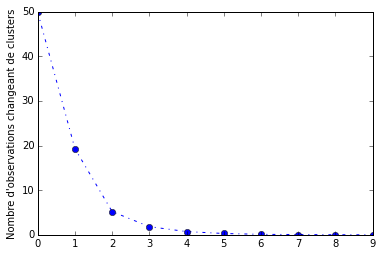

In [57]:
import matplotlib.pyplot as plt
plt.plot(diffs, 'bo', linestyle = '-.')
plt.ylabel("Nombre d'observations changeant de clusters")

#### Remise à l'échelle et téléchargement des données

On « dé-centre » et « dé-réduit » les données.

In [58]:
%%PIG post_traitement.pig
A = LOAD 'output_iter11' using PigStorage(',') as ( f1:float, f2:float, f3:float, face:int, c:int );
B = LOAD 'moyennes' using PigStorage(',') as ( f1m:float, f2m:float, f3m:float );
C = LOAD 'ecartstypes' using PigStorage(',') as ( f1e:float, f2e:float, f3e:float );

D = foreach A GENERATE f1*C.f1e as f1, f2*C.f2e as f2, f3*C.f3e as f3, face, c;
E = foreach D GENERATE f1+B.f1m as f1, f2+B.f2m as f2, f3+B.f3m as f3, face, c;
F = foreach E GENERATE ROUND(f1) as f1, ROUND(f2) as f2, ROUND(f3) as f3, face, c;

STORE F into 'donnees_output' using PigStorage(',') ;

In [59]:
%jobsyntax post_traitement.pig

In [60]:
client.pig_submit("post_traitement.pig", redirection="redirection" )

('', '')

In [61]:
%remote_cmd hdfs dfs -ls donnees_output

In [125]:
%remote_cmd hdfs dfs -tail donnees_output/part-m-00000

In [126]:
%remote_cmd hdfs dfs -getmerge donnees_output donnees_output
%remote_down donnees_output donnees_output.csv
%remote_cmd rm -r donnees_output
os.listdir()

['.ipynb_checkpoints',
 'Brouillion.ipynb',
 'BrouillonCloudera.ipynb',
 'calcul_avg.pig',
 'calcul_frequences.pig',
 'centrer_reduire.pig',
 'diff_cluster.txt',
 'donnees_output.csv',
 'init_random.pig',
 'iteration_complete.pig',
 'nb_obervations.pig',
 'post_traitement.pig',
 'Projet_Kmeans.ipynb',
 'Skin_NonSkin.txt']

#### Représentation en 3D des clusters

In [127]:
import pandas
df = pandas.read_csv('donnees_output.csv', names = ['red', 'blue', 'green', 'face', 'cluster'])
C0 = mean(df[df.cluster==0])
C1 = mean(df[df.cluster==1])

df = df.drop_duplicates()

In [128]:
df

,red,blue,green,face,cluster
0,74,85,123,1,0
1,73,84,122,1,0
2,72,83,121,1,0
3,70,81,119,1,0
5,69,80,118,1,0
8,76,87,125,1,0
10,77,88,126,1,0
13,78,89,127,1,0
14,77,85,125,1,0
15,78,86,126,1,0


Çi-dessous, on représente en 3 dimensions la partition de $\mathbb{R}^3$ produite par notre algorithme. Les deux points en violet sont les centres des clusters.

On n'observe pas de problèmes manifestes dans l'attribution des clusters (chaque point semble bien dans le cluster dont le centre est le plus proche).

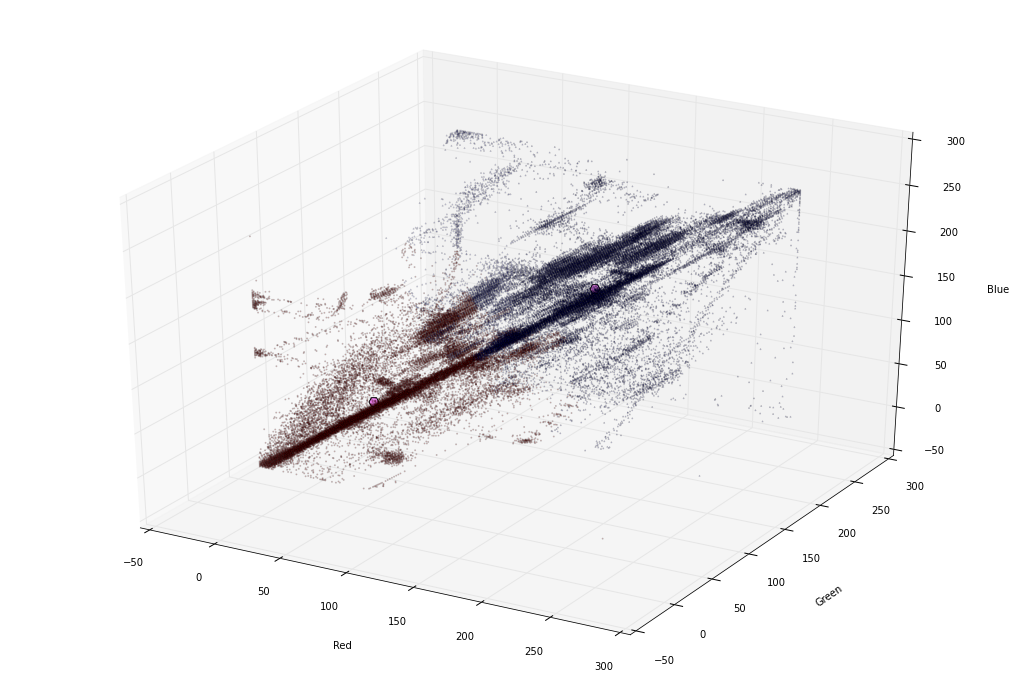

In [131]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
for c, m, cluster in [('r', 'o', 0), ('b', '^', 1)]:
    xs = df.red[df.cluster==cluster]
    ys = df.green[df.cluster==cluster]
    zs = df.blue[df.cluster==cluster]
    ax.scatter(xs, ys, zs, c=c, marker=m, alpha = 0.2, s = 1)

ax.scatter(C0.red, C0.green, C0.blue, c='violet', marker='H', s=100)
ax.scatter(C1.red, C1.green, C1.blue, c='violet', marker='H', s=100)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()

#### Représentation de la variable d'intérêt

La variable d'intérêt est une variable binaire indiquant si le pixel fait partie d'un visage (valeur 1) ou s'il représente autre chose (valeur 2).

On représente cette variable ci-dessous en 3 dimensions, où le rouge représente les visages.

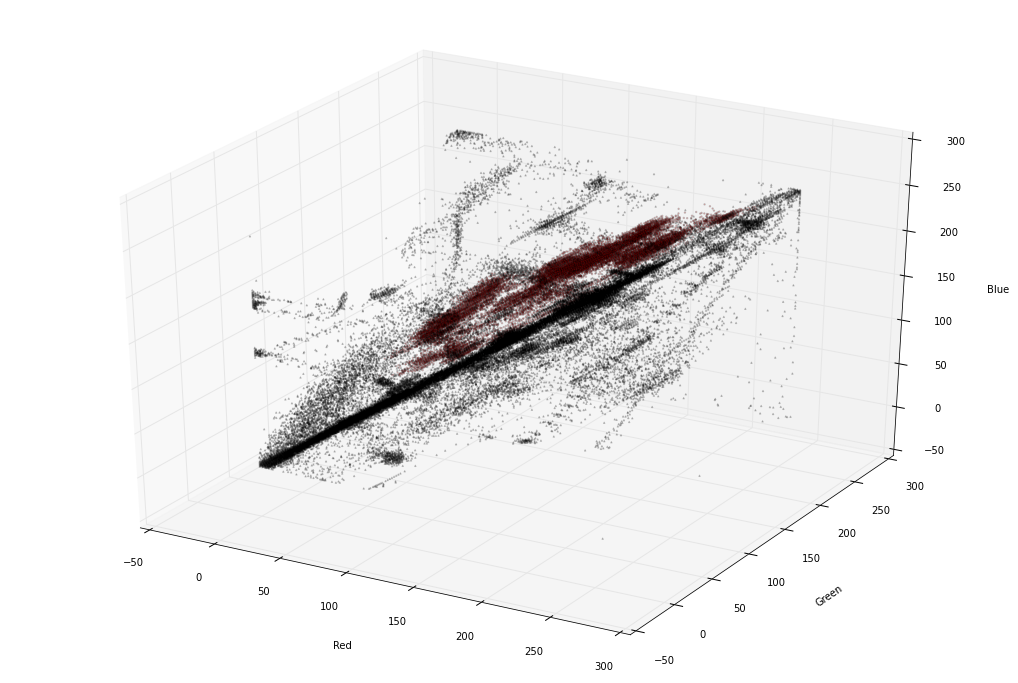

In [140]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
for c, m, y, size in [('black', '^', 2, 2), ('red', 'o', 1, 2)]:
    xs = df.red[df.face==y]
    ys = df.green[df.face==y]
    zs = df.blue[df.face==y]
    ax.scatter(xs, ys, zs, c=c, marker=m, alpha = 0.2, s = size)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()

### Prédicteur

Nous calculons le prédicteur du minimum du risque empirique, c'est à dire, qu'ici on prédit l'étiquette la plus fréquente dans chaque cluster. Pour cela, nous calculons les fréquences dans chaque cluster en utilisant PIG.

In [73]:
%%PIG calcul_frequences.pig
A = LOAD 'output_iter11' using PigStorage(',') as ( f1:float, f2:float, f3:float, face:int, c:int );
B = foreach A GENERATE face-1 as face, c ;
C = group B by c ;
D = foreach C GENERATE group as c, AVG(B.face) ;

STORE D into 'freq_empiriques' using PigStorage(',') ;

In [143]:
%jobsyntax calcul_frequences.pig

In [75]:
client.pig_submit("calcul_frequences.pig", redirection="redirection" )

('', '')

In [76]:
%remote_cmd hdfs dfs -ls freq_empiriques

In [77]:
%remote_cmd hdfs dfs -tail freq_empiriques/part-r-00000

De plus, nous voulons calculer le taux de pixels « non-visage » par rapport aux pixels « visage ».

In [91]:
%%PIG calcul_avg.pig
A = LOAD 'output_iter11' using PigStorage(',') as ( f1:float, f2:float, f3:float, face:int, c:int );
B = foreach A GENERATE (face-1) as face ;
C = group B all ;
D = foreach C GENERATE AVG(B.face) ;

STORE D into 'moyenne_face' using PigStorage(',') ;

In [92]:
%jobsyntax calcul_avg.pig

In [93]:
client.pig_submit("calcul_avg.pig", redirection="redirection" )

('', '')

In [95]:
%remote_cmd hdfs dfs -ls moyenne_face

In [96]:
%remote_cmd hdfs dfs -tail moyenne_face/part-r-00000

Nous observons donc que notre jeu de données contient environ 79% de pixels n'appartenant pas à un visage.

Notre clustering discrimine un peu la variable d'intérêt puisque le premier cluster contient 86% de pixels « non-visage » et le deuxième 75%. Le deuxième (en bleu sur la figure représentant les clusters) semble est donc plus proche des pixels appartenant à des visages. C'est ce que l'on pouvait voir sur les deux figures précédentes en 3 dimensions.

Pourtant, l'étiquette majoritaire reste le « non-visage » dans les deux clusters. C'est sûrement là une limitation de notre implémentation de Kmeans dans le cas d'une utilisation de prédiction d'étiquette : il faudrait augmenter le nombre de clusters pour avoir de meilleurs résultats. C'est aussi une limitation de l'algorithme dans ce cas d'utilisation : les Kmeans reste un algorithme non-supervisé de clustering. Il peut bien sûr être utilisé pour un problème supervisé, mais le fait que la variable d'intérêt ne rentre pas en compte dans l'estimation des clusters peut aboutir à des résultats moins bons que, par exemple, une analyse discriminante linéaire.